# Weighted Averages

This notebook demonstrates some methods for doing weighted averages. It follows the [NCL examples](http://www.ncl.ucar.edu/Applications/ave.shtml). 

Text(0.5, 1.0, 'Global Weighted Average')

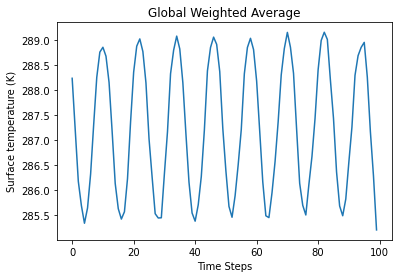

In [13]:
#  Following ave_1.ncl
#
# Concepts illustrated:
#   - Calculating a global weighted average
#   - Drawing a time series plot
#   - Copying attributes from one variable to another
#
# Notes on conversion to python:
#  - We start by doing this with xarray, which makes it very easy.

# Data: 
#   - this file is used in NCL examples, but was located on CGD systems in Dennis Shea's files.
#     /project/cas/shea/netCDF_Misc/b003_TS_200-299.nc
#   - the time coordinate is referenced to year 0, which can cause warnings, so just do not decode times.

# xarray
import xarray as xr
input_data = xr.open_dataset("../data/b003_TS_200-299.nc", decode_times=False)  # Changed very bad variable name "in" to input_data 
ts = input_data['TS']                           # read in data (time, lat, lon)
gw = input_data['gw']                           # get gaussian weights for ave

# calculate averages

# weights are provided in the file. Use that data, and let xarray deal with reshaping as necessary.
# apply mean over lat and lon
# if there are missing data, the calculation will work, but be aware that then the order of operations matters.
# --> in most cases, I think xarray does the most correct thing it can when both spatial dims are provided.
globav = ts.weighted(gw).mean(dim=("lat","lon")) # results in time series

# Create plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(len(ts.time)), globav) # following NCL example's horizontal axis
ax.set_ylabel(f"{ts.attrs['long_name']} ({ts.attrs['units']})")
ax.set_xlabel("Time Steps")
ax.set_title("Global Weighted Average")

# Comparison with NCL example:
# Here we use 11 lines of code including imports (2)
# NCL uses 12 lines (*not* including begin/end)
# BUT we need one more line of code to save the figure, which NCL does:
# fig.savefig("ave.png", bbox_inches="tight")

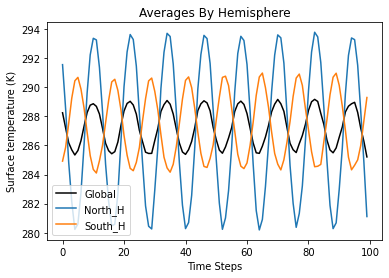

In [18]:
#  Following ave_2.ncl

# Concepts illustrated:
#   - Calculating a hemispheric average
#   - Calculating a weighted average
#   - keeping attributes during operation with keep_attrs kwarg
#   - Drawing an XY plot with multiple curves
#   - Drawing a legend inside an XY plot
#   - Moving an XY plot legend

# calculate averages
# -- globav is exactly the same as above, so just keep it.
# hemisphere averages
nh = ts.sel(lat=slice(0,90)).weighted(gw.sel(lat=slice(0,90))).mean(dim=("lat","lon"), keep_attrs=True)
sh = ts.sel(lat=slice(-90,0)).weighted(gw.sel(lat=slice(-90,0))).mean(dim=("lat","lon"), keep_attrs=True)
# note: this does assume that gw has a coordinate variable (usually will be true)
# I would also usually have a separate variable to define the slice object (nhlat = slice(0,90))

fig, ax = plt.subplots()
ax.plot(range(len(ts.time)), globav, color='black', label="Global") # following NCL example's horizontal axis
ax.plot(range(len(ts.time)), nh, label="North_H") 
ax.plot(range(len(ts.time)), sh, label="South_H") 
ax.set_ylabel(f"{ts.attrs['long_name']} ({ts.attrs['units']})")
ax.set_xlabel("Time Steps")
ax.set_title("Averages By Hemisphere")
ax.legend(loc='lower left')

# Comparison with NCL:
# Here we see that it's a little easier to extend the plot to include all three lines.
# We added two lines of code and used the `label` keyword, and added the legend.
# The NCL code is about 34 lines, and most of the new lines are dealing with the legend and making an extra array to hold all three time series.

## numpy version
Sometimes we've just got numpy arrays instead of xarray objects. Occasionally it is easier or faster to use numpy objects directly _instead_ of xarray objects. In these cases, it is still quite easy to do weighted averages.

The data is now type: <class 'numpy.ndarray'>
Can look at the array shapes directly figure out the correct axis programmatically. Shape: (100, 64, 128)
1


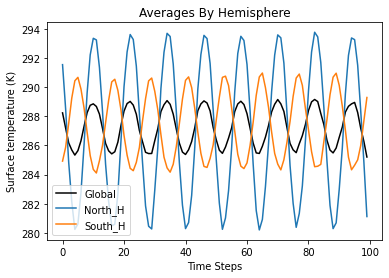

In [37]:
import numpy as np
# reduce to just numpy:
tsnp = ts.values
gwnp = gw.values
print(f"The data is now type: {type(tsnp)}")
print(f"Can look at the array shapes directly figure out the correct axis programmatically. Shape: {tsnp.shape}")
axis_number = tsnp.shape.index(len(gwnp))
print(axis_number)
globav = np.average(tsnp, axis=axis_number, weights=gwnp).mean(axis=-1)

# Doing the hemispheres requires knowing the latitudes OR assuming that half the latitude axis is a hemisphere,
# but you must know which direction the data is oriented
# Here we get the latitudes (as a numpy array),
#   - get the indices that define the hemisphere
#   - use `take` to extract the temperature data for the given hemisphere
#   - slice the weights array for the hemisphere
#   - use average with the weights
# ** this would usually be encapsulated in a little function **
lat = input_data['lat'].values 
nh_lat_indices = np.argwhere(lat > 0)
nh_ts = tsnp.take(indices=nh_lat_indices.flatten(), axis=axis_number)
nh_wgt = gwnp[nh_lat_indices.flatten()]
nh = np.average(nh_ts, axis=axis_number, weights=nh_wgt).mean(axis=-1)

sh_lat_indices = np.argwhere(lat < 0)
sh_ts = tsnp.take(indices=sh_lat_indices.flatten(), axis=axis_number)
sh_wgt = gwnp[sh_lat_indices.flatten()]
sh = np.average(sh_ts, axis=axis_number, weights=sh_wgt).mean(axis=-1)

fig, ax = plt.subplots()
ax.plot(range(tsnp.shape[0]), globav, color='black', label="Global") # following NCL example's horizontal axis
ax.plot(range(tsnp.shape[0]), nh, label="North_H") 
ax.plot(range(tsnp.shape[0]), sh, label="South_H") 
ax.set_ylabel(f"{ts.attrs['long_name']} ({ts.attrs['units']})")  # we would need to know this if we don't have metadata
ax.set_xlabel("Time Steps")
ax.set_title("Averages By Hemisphere")
ax.legend(loc='lower left')


## weights in two dimensions

The third example in NCL uses `wgt_volave_ccm`. That provides a weighted average in the vertical as well as latitude.

I don't have the file for that example, so I selected an arbitrary CESM2 file that has the hybrid-sigma coefficients, surface pressure, and specific humidity.

The NCL example shows a map, but the map is **not** the weighted average, so we omit that here.

This example is specific to a pressure-weighted average because don't apply a simple 1-dimensional vector as the vertical weight. Instead, we have to derive the full-dimension pressure field as approximated from the hybrid-sigma coefficients and the surface pressure. From that we get the pressure thickness at each level, which are the "weights". The weights are column-wise, so we need to apply the average at each column. That could be done with the regular definition of the weighted average
\begin{equation}
\langle q \rangle = \frac{\sum q(p) \times dp}{\sum dp}
\end{equation}
But we can make it a little more efficient by normalizing the weights ahead of time, reducing the averate to a weighted sum. 

The result is a vertically-averaged $q$, which can then be area-weighted average just like above. 

NCL provides `wgt_volave_ccm` (and several similar functions) as a convenience to this series of steps.

In [41]:
ds3 = xr.open_dataset("/Volumes/Jedha/cloud_locking/B1850_c201_CTL/B1850_c201_CTL.cam.h0.0001-01.ncrcat.Q.nc")
# extract just the first year of data:
ps = ds3['PS'].isel(time=slice(0,12)) # Pa
q = ds3['Q'].isel(time=slice(0,12))   # kg/kg
hyai = ds3['hyai']
hybi = ds3['hybi']
p0 = 100000.0

In [64]:
# Derive pressure thicknesses of the layers
# This is the same as dp = dpres_hybrid_ccm(ps,p0,hya,hyb)
pressure_field =  hyai*p0 + hybi*ps  # Pa
lev_axis_number = pressure_field.dims.index("ilev") # it's called ilev b/c hyai and hybi use that
dp = np.absolute(np.diff(pressure_field, axis=lev_axis_number)) # will be same shape as q, but might need to be re-ordered
dp = np.swapaxes(dp, 0, 1)

In [93]:
# dp is time, lev, lat, lon
# But only represents weights in the column, so we apply the vertical average first:
dp_sum_of_weights = np.sum(dp, axis=1)
dp_sum_of_weights = np.expand_dims(dp_sum_of_weights, axis=1)
print(dp_sum_of_weights.shape)
dp_weights = dp / dp_sum_of_weights  # normalization => dp_weights.sum(axis=1) == 1
vertical_average = (q*dp_weights).sum(axis=1) # units are the same as q => kg/kg

# note that this is DIFFERENT than the vertical integral:
vertical_integral = (q*dp).sum(axis=1) / 9.81 # divide by g to mass weight & get units => This is approx. TMQ, i.e. precipitable water

(12, 1, 192, 288)


In [73]:
global_volume_average = (q*dp_weights).sum(axis=1).weighted(np.cos(np.radians(q.lat))).mean(dim=("lat","lon")) # treats months equally

In [75]:
print(global_volume_average)


<xarray.DataArray 'Q' (time: 12)>
array([0.00225881, 0.00227965, 0.00228066, 0.00231691, 0.00237731,
       0.00246528, 0.00255202, 0.00252361, 0.00241239, 0.002321  ,
       0.00224713, 0.00222238])
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0002-01-01 00:00:00
